# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
# !pip install tensorflow==2.3

In [2]:
# #аугментации изображений
# !pip install albumentations 

In [3]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 730 kB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 1.9 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import pymorphy2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
import albumentations

# Imports from our package
# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.tasks import Task

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
# функция ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [12]:
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [13]:
test['brand'].value_counts(normalize=True)

BMW         0.436864
MERCEDES    0.330341
AUDI        0.232795
Name: brand, dtype: float64

In [14]:
train['brand'].value_counts(normalize=True)

BMW         0.419784
MERCEDES    0.343310
AUDI        0.236905
Name: brand, dtype: float64

Как видим, распределение марок автомобилей в тренировочном и тестовом датасете одинаковое. Так что с этим все ок

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [15]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [16]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

In [17]:
# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

In [18]:
## Посмотрим на данные
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [19]:
# Посмотрим на пропуски в данных о владельцах
train[train['Владельцы'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,...,600000.0,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый


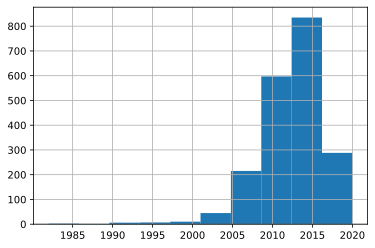

In [20]:
# Проверка распределения частот
train[train['Владельцы']=='2\xa0владельца']['productionDate'].hist()

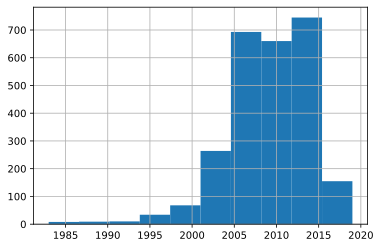

In [21]:
# Проверка распределения частот
train[train['Владельцы']=='3 или более']['productionDate'].hist()

In [22]:
# Заполним пропущенные значения
train.loc[train['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'

In [23]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


In [24]:
# Проверим наличие дупликатов
train.duplicated().value_counts()

False    6682
dtype: int64

In [25]:
# Проверим наличие дупликатов
test.duplicated().value_counts()

False    1671
dtype: int64

In [26]:
# Объединяем данные.
train['sample'] = 1
test['sample'] = 0
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)

In [27]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0


### 3.1 Body Type

In [28]:
data['bodyType'].value_counts()

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

### 3.2 Brand

In [29]:
data['brand'].value_counts()

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

### 3.3 Сolor

In [30]:
data['color'].value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

### 3.4 Description

In [31]:
data['description'][0]

'Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n650 Спорт

### 3.5 Engine Displacement

In [32]:
data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
3.6 LTR            23
4.1 LTR            23
1.7 LTR            15
3.7 LTR            14
2.3 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
1.9 LTR             5
4.6 LTR             5
6.6 LTR             5
5.8 LTR             5
4.3 LTR             4
3.4 LTR             4
6.3 LTR             3
3.8 LTR   

In [33]:
# Checking the data.
data[data['engineDisplacement'] == 'undefined LTR']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
1005,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,...,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.0
3967,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,...,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2719000.0
5396,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,...,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый,1,2299711.0
5397,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,...,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2170000.0
7533,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,...,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1690000.0
7954,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,...,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1790000.0


In [34]:
# Функция отрисовки BOXPLOT
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, 
                y='price',
                data=train.loc[
                    train.loc[:, column].isin(train.loc[:, column].value_counts().index)
                ],
                ax=ax)
    plt.xticks(rotation=90)
    ax.set_title('Boxplot для ' + column)
    plt.show()

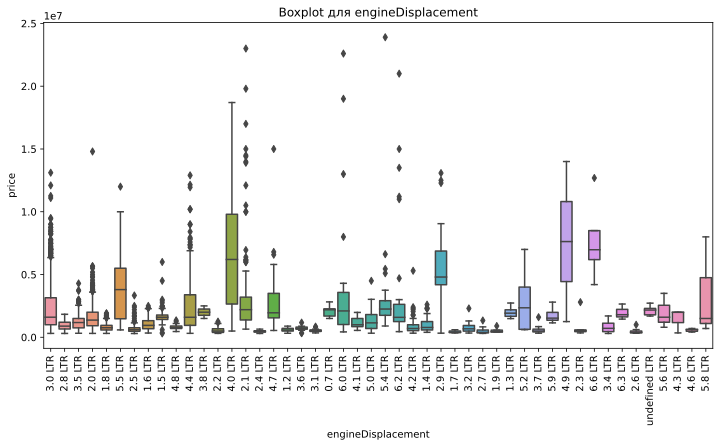

In [35]:
# Проверим распределение значений
get_boxplot('engineDisplacement')

Наибольшее подходящее распределение эектромобилям 1.3 LTR

In [36]:
# Вносим изменения
data.loc[data['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '1.3 LTR'

In [37]:
# Переведем литры в милилитры
data['engineDisplacement'] = data['engineDisplacement'].str.split().apply(
    lambda s: s[0]
)

data['engineDisplacement'] = data['engineDisplacement'].apply(
    lambda s: float(s)
)

data['engineDisplacement'] = data['engineDisplacement']*1000

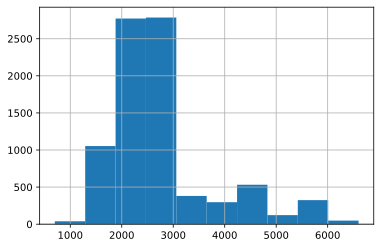

In [38]:
# Проверим распределение значений
data['engineDisplacement'].hist()

Распределение не нормальное. Давайте произведем логарифмирование признака

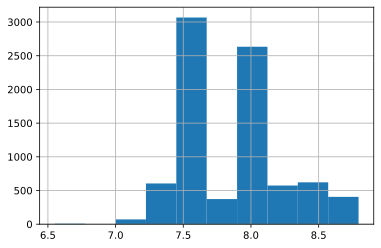

In [39]:
# посмотрим распределение признака после логарифмирования
np.log(data['engineDisplacement']).hist()

### 3.6 Engine Power

In [40]:
data['enginePower'].value_counts()

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
430 N12      1
114 N12      1
321 N12      1
457 N12      1
174 N12      1
Name: enginePower, Length: 154, dtype: int64

In [41]:
# Переведем признак в числовой
data['enginePower'] = data['enginePower'].str.split().apply(
    lambda s: s[0]
)

data['enginePower'] = data['enginePower'].apply(
    lambda s: float(s)
)

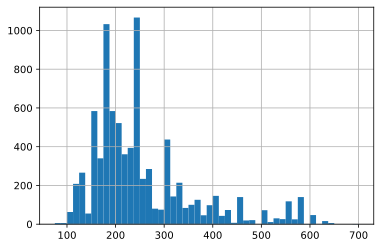

In [42]:
# Посмотрим на распределение
data['enginePower'].hist(bins=50)

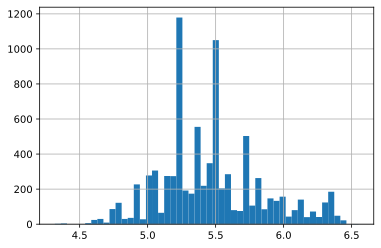

In [43]:
# Проверим логарифмирование признака.
np.log(data['enginePower']).hist(bins=50)

### 3.7 Fuel Type

In [44]:
data['fuelType'].value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

### 3.8 Mileage

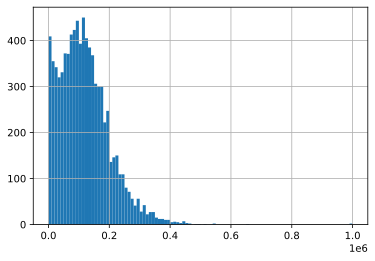

In [45]:
# Посмотрим на распределение
data['mileage'].hist(bins=100)

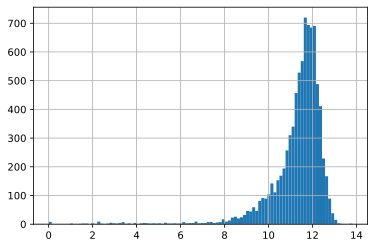

In [46]:
# Проводим логарифмирование.
np.log(data['mileage']).hist(bins=100)

### 3.9 Model Date

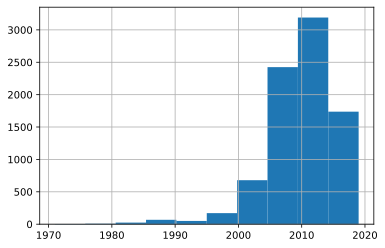

In [47]:
# Распределение признака
data['modelDate'].hist()

In [48]:
# Модифицируем дату.
data['modelDate'] = 2021 - data['modelDate']

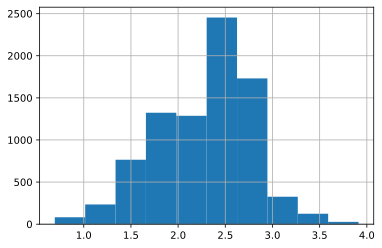

In [49]:
# Распределение признака после логаримирования
np.log(data['modelDate']).hist()

### 3.10 Model Info

In [50]:
data['model_info'].value_counts()

5ER               776
3ER               578
X5                501
E_KLASSE          490
A6                433
                 ... 
COUPE               1
SQ7                 1
SLC_KLASSE_AMG      1
Z1                  1
CITAN               1
Name: model_info, Length: 122, dtype: int64

In [51]:
data[data['model_info'] == '100']['description']

6275    Продаю S4 1994 года, последний год выпуска S4 ...
Name: description, dtype: object

In [52]:
data[data['model_info'] == 'COUPE']['description']

1646    Собственник 10 лет в одних руках. Есть вся ист...
Name: description, dtype: object

In [53]:
data[data['model_info'] == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4000.0,510.0,бензин,41000,7,None,...,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0


In [54]:
# Внесем измения
data.loc[data['model_info'] == '100', 'model_info'] = 'S4'
data.loc[data['model_info'] == 'COUPE', 'model_info'] = 'S2'
data.loc[data['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'

### 3.11 Name

In [55]:
data['name']

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
8348                320i 2.0 AT (150 л.с.)
8349               520d 2.0d AT (190 л.с.)
8350                318i 2.0 AT (143 л.с.)
8351            Long 3.0 AT (310 л.с.) 4WD
8352             Pullman 6.0 AT (394 л.с.)
Name: name, Length: 8353, dtype: object

Этот признак дублирует значения из других столбцов. Удалим его позже

### 3.12 Number of Doors

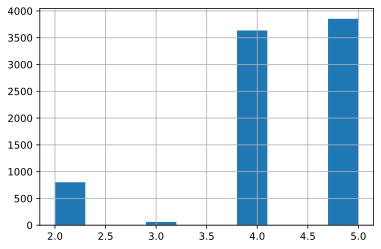

In [56]:
# Распределение признака
data['numberOfDoors'].hist()

### 3.13 Production Date

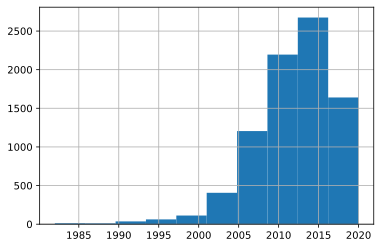

In [57]:
# Распределение признака
data['productionDate'].hist()

In [58]:
# Изменим данные.
data['productionDate'] = 2021 - data['productionDate']

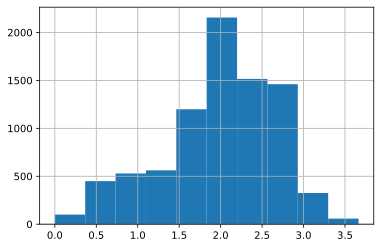

In [59]:
# Проведем логарифмирование.
np.log(data['productionDate']).hist()

### 3.14 Sell ID

In [60]:
data['sell_id']

0       1099427284
1       1096405886
2       1100195294
3       1099827282
4       1100076198
           ...    
8348    1100036650
8349    1090506038
8350    1095155628
8351    1099625256
8352    1097146066
Name: sell_id, Length: 8353, dtype: int64

Удалим столбец позже

### 3.15 Vehicle Configuration

In [61]:
data['vehicleConfiguration']

0       WAGON_5_DOORS AUTOMATIC 3.0
1               COUPE AUTOMATIC 3.0
2               COUPE AUTOMATIC 2.5
3               SEDAN AUTOMATIC 2.0
4               SEDAN AUTOMATIC 2.0
                   ...             
8348            SEDAN AUTOMATIC 2.0
8349            SEDAN AUTOMATIC 2.0
8350            SEDAN AUTOMATIC 2.0
8351            SEDAN AUTOMATIC 3.0
8352        LIMOUSINE AUTOMATIC 6.0
Name: vehicleConfiguration, Length: 8353, dtype: object

Значения столбца имеются в других признаках. Удалим его позже

### 3.16 Vehicle Transmission

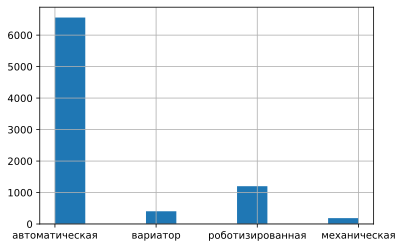

In [62]:
# Проверим распределение признака
data['vehicleTransmission'].hist()

### 3.17 Owners

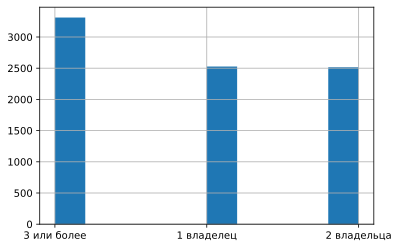

In [63]:
# Распределение признака
data['Владельцы'].hist()

In [64]:
# Это категорийный признак. Внесем изменения
owners_dict = {
    '1\xa0владелец': 1,
    '2\xa0владельца': 2,
    '3 или более': 3
}

data['Владельцы'] = data['Владельцы'].map(owners_dict)

In [65]:
# Прверим
data['Владельцы'].value_counts()

3    3312
1    2526
2    2515
Name: Владельцы, dtype: int64

### 3.18 Ownership Time

In [66]:
data['Владение'].value_counts(dropna=False)

NaN                    5418
1 год и 8 месяцев        67
1 год и 2 месяца         67
1 год                    55
9 месяцев                52
                       ... 
17 лет                    1
13 лет и 8 месяцев        1
11 лет и 1 месяц          1
15 лет и 10 месяцев       1
17 лет и 4 месяца         1
Name: Владение, Length: 181, dtype: int64

Много пропущенных значений. Мы удалим его позже.

### 3.19 Registration Certificate

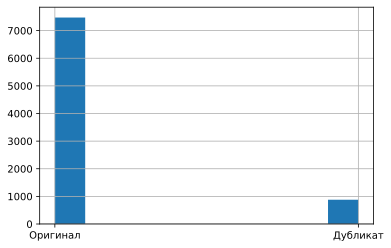

In [67]:
# Распределение признака
data['ПТС'].hist()

In [68]:
# Это категорийный признак. Внесем изменения
passport_dict = {
    'Дубликат': 0,
    'Оригинал': 1,
}

data['ПТС'] = data['ПТС'].map(passport_dict)

In [69]:
# Проверим
data['ПТС'].value_counts()

1    7474
0     879
Name: ПТС, dtype: int64

### 3.20 Car Layout

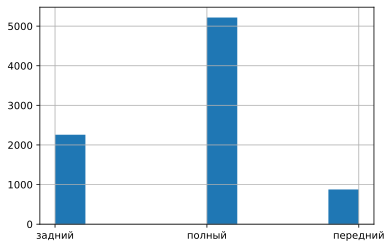

In [70]:
# Распределение признака
data['Привод'].hist()

### 3.21 Wheel Position

In [71]:
data['Руль'].value_counts()

Левый     8351
Правый       2
Name: Руль, dtype: int64

In [72]:
data[data['Руль'] == 'Правый']['sample']

2778    1
3188    1
Name: sample, dtype: int64

На самом деле, все автомобили в наборе данных являются левосторонними. Обе машины с правым рулем находятся в тренировочном наборе данных. Кандидат на удаление.

### 3.22 Price

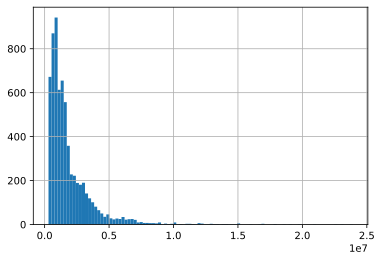

In [73]:
# Распределение цены
train['price'].hist(bins=100)

### 4. Feature Engineering

In [74]:
# Создадим новые признаки
popular_colors = [
    'чёрный', 
    'белый', 
    'серый', 
    'синий'
]

rare_colors = [
    'серебристый',
    'коричневый',
    'красный'
]

data['popular_color'] = 0
data['rare_color'] = 0
data['very_rare_color'] = 0

In [75]:
# Создаем новые признаки
counter = 0

for color in data['color']:
    if color in popular_colors:
        data.at[counter,'popular_color'] = 1
        counter += 1
    elif color in rare_colors:
        data.at[counter,'rare_color'] = 1
        counter += 1
    else:
        data.at[counter,'very_rare_color'] = 1
        counter += 1

In [76]:
# Cоздаем новые признаки
data['mileage_to_age'] = data['mileage']/data['productionDate']

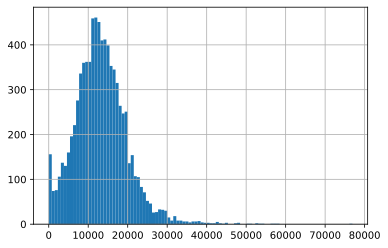

In [77]:
# Проверим распределение признака
data['mileage_to_age'].hist(bins=100)

In [78]:
# Создаем новые признаки
data['low_MtA'] = 0
data['high_MtA'] = 0


In [79]:
# Создаем новые признаки
counter = 0

for MtA in data['mileage_to_age']:
    if MtA < 5000:
        data.at[counter,'low_MtA'] = 1
        counter += 1
    elif MtA > 30000:
        data.at[counter,'high_MtA'] = 1
        counter += 1
    else:
        counter += 1

### Выбор значимых признаков

In [80]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   float64
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Привод,Руль,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age,low_MtA,high_MtA
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3000.0,220.0,бензин,350000,37,W124,...,задний,Левый,0,0.0,1,0,0,11666.666667,0,0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3000.0,313.0,дизель,15000,10,6ER,...,полный,Левый,0,0.0,1,0,0,1875.000000,1,0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2500.0,218.0,бензин,166600,16,3ER,...,полный,Левый,0,0.0,0,0,1,12815.384615,0,0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2000.0,136.0,бензин,147000,16,3ER,...,задний,Левый,0,0.0,1,0,0,10500.000000,0,0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2000.0,190.0,дизель,24000,5,5ER,...,полный,Левый,0,0.0,1,0,0,12000.000000,0,0


In [81]:
# Проверим вторую запись
data.loc[1]

bodyType                                                             купе
brand                                                                 BMW
color                                                               белый
description             Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
engineDisplacement                                                   3000
enginePower                                                           313
fuelType                                                           дизель
mileage                                                             15000
modelDate                                                              10
model_info                                                            6ER
name                                   640d xDrive 3.0d AT (313 л.с.) 4WD
numberOfDoors                                                           2
productionDate                                                          8
sell_id                               

In [82]:
# Создадим списки с категориями признаков

categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'Владельцы',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'low_MtA', 
    'high_MtA',
    'ПТС'
]

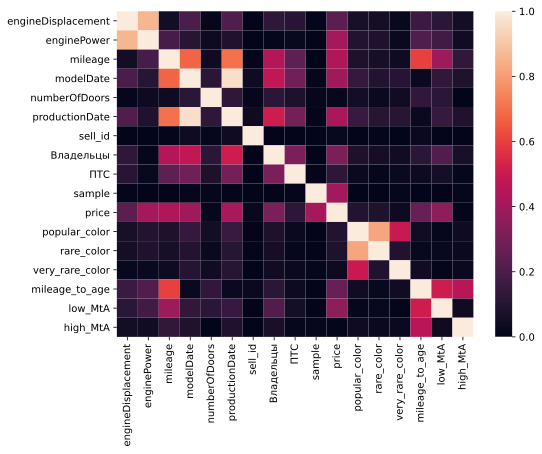

In [83]:
# Посмотрим на тепловую карту корреляции признаков
plt.subplots(figsize=(8,6))
sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

In [84]:
# Таблица корреляции признаков
data.corr().abs().sort_values(by='price', ascending=False)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,ПТС,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age,low_MtA,high_MtA
price,0.241048,0.404552,0.436743,0.397267,0.018068,0.417464,0.019779,0.309139,0.118204,0.405771,1.000000,0.090281,0.081155,0.034027,0.269509,0.363177,0.011580
mileage,0.049378,0.184616,1.000000,0.672522,0.038435,0.702970,0.010300,0.444289,0.245004,0.003900,0.436743,0.074997,0.061223,0.037765,0.601572,0.387977,0.132702
productionDate,0.209931,0.085100,0.702970,0.964919,0.124278,1.000000,0.042841,0.507794,0.298051,0.008146,0.417464,0.150023,0.105450,0.101656,0.027846,0.144646,0.083566
sample,0.009001,0.004199,0.003900,0.011782,0.014501,0.008146,0.000134,0.003877,0.008624,1.000000,0.405771,0.003183,0.005860,0.014577,0.003277,0.004362,0.013423
enginePower,0.860317,1.000000,0.184616,0.101825,0.031772,0.085100,0.000859,0.012214,0.019801,0.004199,0.404552,0.089958,0.084783,0.027894,0.209323,0.175343,0.044136
modelDate,0.195373,0.101825,0.672522,1.000000,0.112091,0.964919,0.038045,0.475524,0.285476,0.011782,0.397267,0.136801,0.092767,0.097896,0.023480,0.132525,0.079163
low_MtA,0.110077,0.175343,0.387977,0.132525,0.110394,0.144646,0.005904,0.209073,0.053009,0.004362,0.363177,0.013798,0.022707,0.010606,0.506134,1.000000,0.039769
Владельцы,0.122053,0.012214,0.444289,0.475524,0.112461,0.507794,0.004910,1.000000,0.311522,0.003877,0.309139,0.075965,0.056501,0.046710,0.113091,0.209073,0.066356
mileage_to_age,0.153173,0.209323,0.601572,0.023480,0.130783,0.027846,0.024568,0.113091,0.032032,0.003277,0.269509,0.043919,0.020602,0.045512,1.000000,0.506134,0.456944
engineDisplacement,1.000000,0.860317,0.049378,0.195373,0.011746,0.209931,0.006186,0.122053,0.105635,0.009001,0.241048,0.063556,0.057748,0.023008,0.153173,0.110077,0.048207


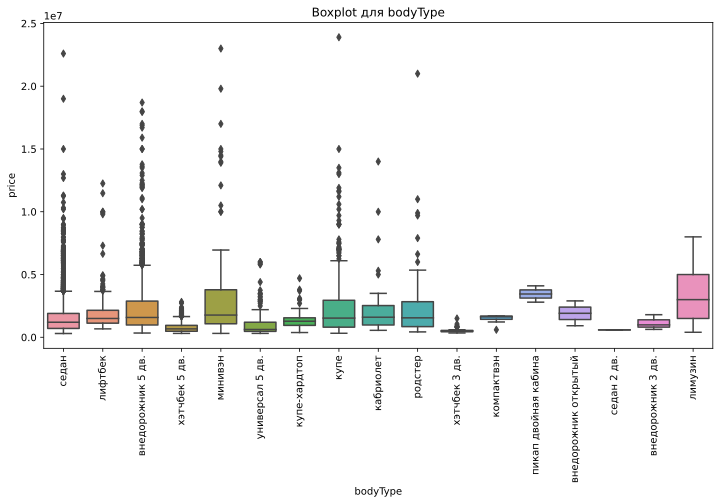

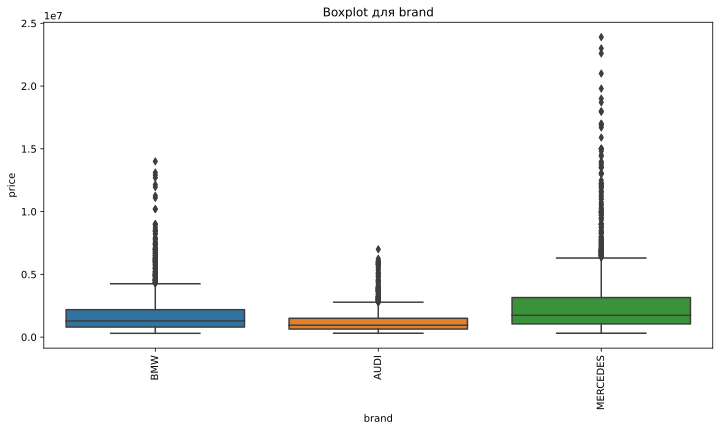

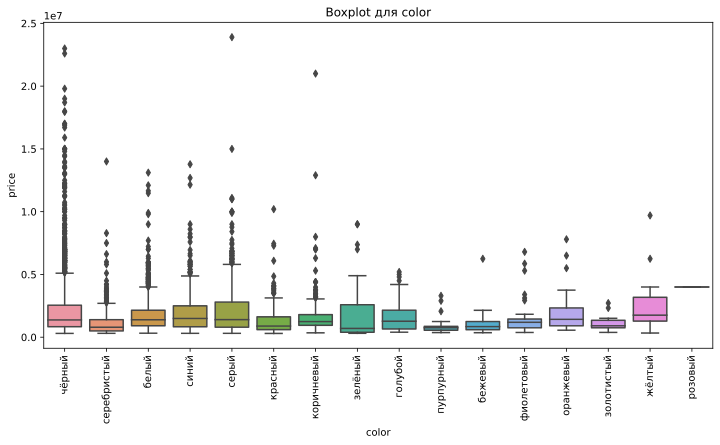

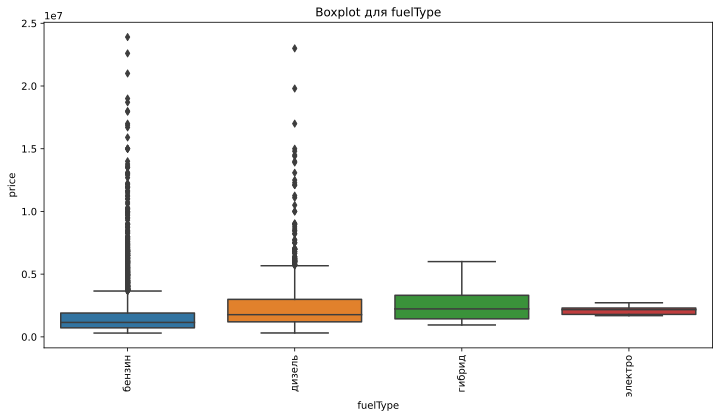

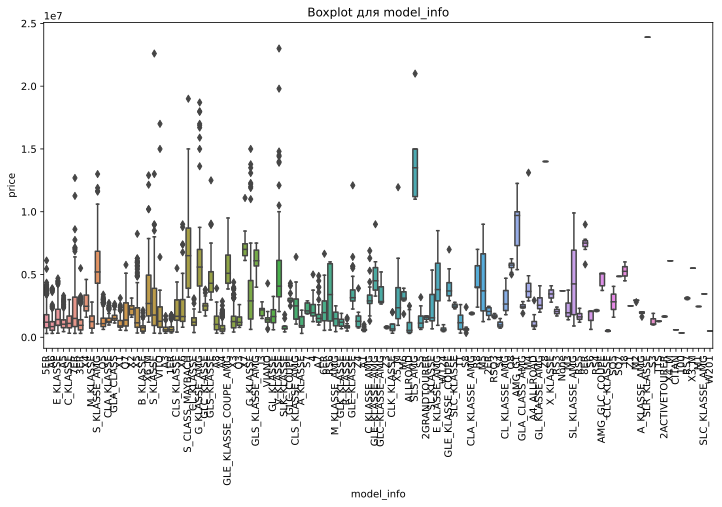

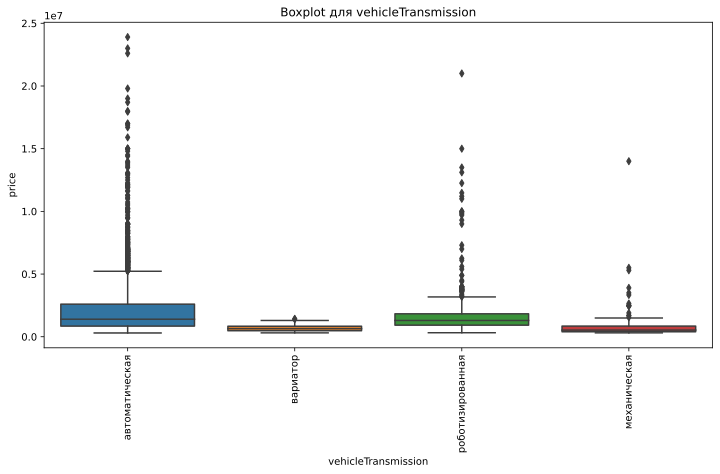

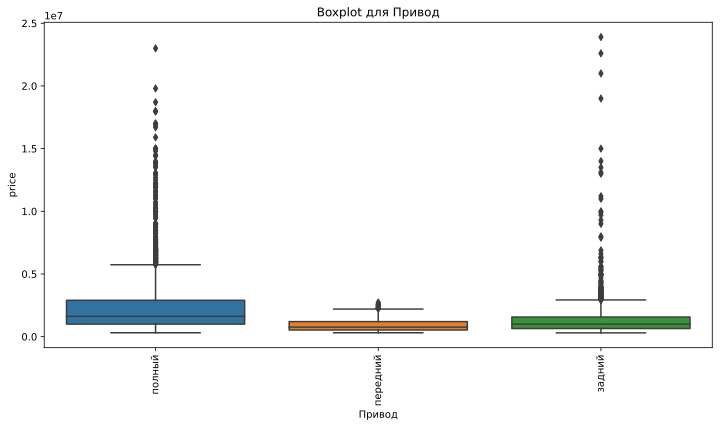

In [86]:
# Посмотрим на Boxplot для категорийных признаков
for col in categorical_features:
    get_boxplot(col)

In [87]:
# Функция теста Стьюдента для статистически значимых признаков
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all):
            print('Статистически значимые различия были обнаружены для столбца', column)
            break

In [88]:
# Проведем тест Стьюдента для категорийных признаков
for col in categorical_features:
    get_stat_dif(col)

Статистически значимые различия были обнаружены для столбца bodyType
Статистически значимые различия были обнаружены для столбца brand
Статистически значимые различия были обнаружены для столбца color
Статистически значимые различия были обнаружены для столбца fuelType
Статистически значимые различия были обнаружены для столбца model_info
Статистически значимые различия были обнаружены для столбца vehicleTransmission
Статистически значимые различия были обнаружены для столбца Привод


# Преобразование данных

In [89]:
categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'Владельцы',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'low_MtA', 
    'high_MtA',
    'ПТС'
]

In [90]:
# Создадим функцию для подготовки данных
def preproc_data(df_input):

    # Создаем копию данных
    df_output = df_input.copy()
    
    # Удаляем ненужные столбцы
    df_output.drop([
        'description',
        'name',
        'sell_id',
        'vehicleConfiguration',
        'Владение',
        'Руль'
    ], axis = 1, inplace=True)
    
    # Проводим логарифмирование
    data['enginePower'] = np.log(data['enginePower'])
    data['mileage'] = np.log(data['mileage'])
    data['engineDisplacement'] = np.log(data['enginePower'])
    data['modelDate'] = np.log(data['mileage'])
    data['productionDate'] = np.log(data['mileage'])
    
    # Делаем нормализацию для числовых признаков
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # One-hot encoding.
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    df_output = pd.get_dummies(
        df_output, 
        columns=categorical_features, 
        dummy_na=False
    )
    
    return df_output

In [91]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Привод,Руль,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age,low_MtA,high_MtA
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3000.0,220.0,бензин,350000,37,W124,...,задний,Левый,0,0.0,1,0,0,11666.666667,0,0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3000.0,313.0,дизель,15000,10,6ER,...,полный,Левый,0,0.0,1,0,0,1875.000000,1,0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2500.0,218.0,бензин,166600,16,3ER,...,полный,Левый,0,0.0,0,0,1,12815.384615,0,0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2000.0,136.0,бензин,147000,16,3ER,...,задний,Левый,0,0.0,1,0,0,10500.000000,0,0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2000.0,190.0,дизель,24000,5,5ER,...,полный,Левый,0,0.0,1,0,0,12000.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2000.0,150.0,бензин,232777,16,3ER,...,задний,Левый,1,550000.0,1,0,0,15518.466667,0,0
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2000.0,190.0,дизель,33700,8,5ER,...,задний,Левый,1,1900000.0,1,0,0,6740.000000,0,0
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2000.0,143.0,бензин,200000,13,3ER,...,задний,Левый,1,530000.0,1,0,0,15384.615385,0,0
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3000.0,310.0,бензин,72000,8,A8,...,полный,Левый,1,1970000.0,1,0,0,14400.000000,0,0


In [92]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
df_preproc.info()
df_preproc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(7), uint8(167)
memory usage: 2.4 MB


,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,sample,price,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
0,0.389831,0.2320,0.349999,0.729167,1.000000,0.763158,1.0,1,0,0.0,...,0,0,0,1,0,0,0,1,0,0
1,0.389831,0.3808,0.014999,0.166667,0.000000,0.184211,0.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,0.305085,0.2288,0.166599,0.291667,0.000000,0.315789,1.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,0.220339,0.0976,0.146999,0.291667,0.666667,0.342105,0.5,1,0,0.0,...,0,0,0,1,0,0,0,1,0,0
4,0.220339,0.1840,0.023999,0.062500,0.666667,0.026316,0.0,1,0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [94]:
df_preproc.sample(4)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,sample,price,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
7399,0.220339,0.272,0.106999,0.104167,1.000000,0.131579,0.0,1,1,1590000.0,...,0,0,0,1,0,0,0,0,0,1
4273,0.220339,0.272,0.044999,0.125000,1.000000,0.105263,0.0,1,1,3100000.0,...,0,0,0,1,0,0,0,0,0,1
3362,0.813559,0.816,0.054999,0.125000,0.666667,0.131579,1.0,1,1,3750000.0,...,0,0,0,1,0,0,0,0,0,1
2794,0.389831,0.272,0.124999,0.166667,0.666667,0.236842,1.0,1,1,1990000.0,...,0,0,0,0,0,0,1,0,0,1


In [95]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(7), uint8(167)
memory usage: 2.4 MB


## Split data

In [96]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [97]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 182 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(6), uint8(167)
memory usage: 481.4 KB


# Model 2: CatBoostRegressor

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [99]:
# Обучение CatBoost
model = CatBoostRegressor(
    iterations=8000,
    random_seed=RANDOM_SEED,
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    od_wait=500
)
                          
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose_eval=100,
    use_best_model=True
)

test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

Learning rate set to 0.017515
0:	learn: 0.9913318	test: 1.0156533	best: 1.0156533 (0)	total: 53.4ms	remaining: 7m 7s
100:	learn: 0.3561095	test: 0.3579898	best: 0.3579898 (100)	total: 363ms	remaining: 28.4s
200:	learn: 0.2546590	test: 0.2534528	best: 0.2534528 (200)	total: 644ms	remaining: 25s
300:	learn: 0.2199972	test: 0.2180206	best: 0.2180206 (300)	total: 918ms	remaining: 23.5s
400:	learn: 0.1946912	test: 0.1947151	best: 0.1947151 (400)	total: 1.2s	remaining: 22.8s
500:	learn: 0.1807983	test: 0.1823781	best: 0.1823781 (500)	total: 1.48s	remaining: 22.2s
600:	learn: 0.1739417	test: 0.1760098	best: 0.1760098 (600)	total: 1.77s	remaining: 21.8s
700:	learn: 0.1674728	test: 0.1705994	best: 0.1705994 (700)	total: 2.09s	remaining: 21.8s
800:	learn: 0.1618663	test: 0.1648844	best: 0.1648844 (800)	total: 2.4s	remaining: 21.5s
900:	learn: 0.1563091	test: 0.1595056	best: 0.1595056 (900)	total: 2.87s	remaining: 22.6s
1000:	learn: 0.1516470	test: 0.1562451	best: 0.1562451 (1000)	total: 3.24s	re

## MAPE: 12.73% (13.23% - Baseline)

In [100]:
# Делаем сабмит
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Простая полносвязная нейросеть

In [101]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,ПТС,popular_color,rare_color,...,model_info_117,model_info_118,model_info_119,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2
7320,0.898305,0.7504,0.149999,0.229167,0.666667,0.236842,0.0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
8037,0.220339,0.2720,0.020941,0.062500,1.000000,0.052632,0.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
4681,0.406780,0.2880,0.133896,0.312500,0.666667,0.368421,1.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
6014,0.186441,0.1744,0.329999,0.270833,0.666667,0.342105,1.0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
3649,0.389831,0.3808,0.125999,0.166667,0.666667,0.184211,0.0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


In [102]:
X_train.shape[1]

181

In [103]:
# Создаем модель
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
                                                                                         l2=0.000000001), activation="relu"))

model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.000000001,
                                                             l2=0.000000001), activation="relu"))

model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [104]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               93184     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 224,769
Trainable params: 224,769
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Задаем оптимайзер Adam с шагом 0.01
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [106]:
# Добавляем checkpoint
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

Epoch 1/560
23/23 [==============================] - 0s 13ms/step - loss: 99.9285 - MAPE: 99.9285 - val_loss: 99.5139 - val_MAPE: 99.5139
Epoch 2/560
23/23 [==============================] - 0s 5ms/step - loss: 96.9173 - MAPE: 96.9173 - val_loss: 90.4522 - val_MAPE: 90.4522
Epoch 3/560
23/23 [==============================] - 0s 5ms/step - loss: 75.8546 - MAPE: 75.8545 - val_loss: 54.7479 - val_MAPE: 54.7477
Epoch 4/560
23/23 [==============================] - 0s 5ms/step - loss: 51.4203 - MAPE: 51.4201 - val_loss: 49.8855 - val_MAPE: 49.8853
Epoch 5/560
23/23 [==============================] - 0s 5ms/step - loss: 48.5361 - MAPE: 48.5359 - val_loss: 47.3096 - val_MAPE: 47.3094
Epoch 6/560
23/23 [==============================] - 0s 5ms/step - loss: 46.7832 - MAPE: 46.7830 - val_loss: 45.4225 - val_MAPE: 45.4223
Epoch 7/560
23/23 [==============================] - 0s 4ms/step - loss: 44.6685 - MAPE: 44.6682 - val_loss: 43.6707 - val_MAPE: 43.6705
Epoch 8/560
23/23 [=====================

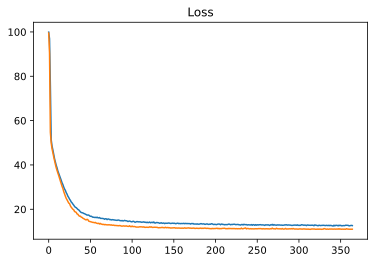

TEST mape: 11.00%


In [107]:
# Обучаем
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=560, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

Epoch 1/560
45/45 [==============================] - 0s 6ms/step - loss: 12.5801 - MAPE: 12.5772 - val_loss: 10.9323 - val_MAPE: 10.9294
Epoch 2/560
45/45 [==============================] - 0s 8ms/step - loss: 12.2835 - MAPE: 12.2806 - val_loss: 10.9576 - val_MAPE: 10.9547
Epoch 3/560
45/45 [==============================] - 0s 3ms/step - loss: 12.4593 - MAPE: 12.4563 - val_loss: 10.9295 - val_MAPE: 10.9265
Epoch 4/560
45/45 [==============================] - 0s 3ms/step - loss: 12.3887 - MAPE: 12.3858 - val_loss: 10.9631 - val_MAPE: 10.9602
Epoch 5/560
45/45 [==============================] - 0s 3ms/step - loss: 12.4223 - MAPE: 12.4193 - val_loss: 10.9429 - val_MAPE: 10.9400
Epoch 6/560
45/45 [==============================] - 0s 3ms/step - loss: 12.3899 - MAPE: 12.3870 - val_loss: 10.9442 - val_MAPE: 10.9413
Epoch 7/560
45/45 [==============================] - 0s 3ms/step - loss: 12.4306 - MAPE: 12.4277 - val_loss: 10.9800 - val_MAPE: 10.9771
Epoch 8/560
45/45 [======================

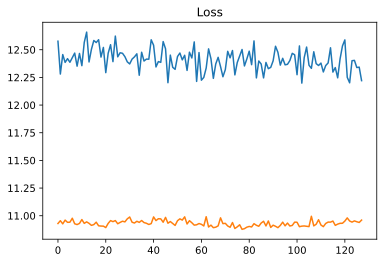

TEST mape: 10.96%


In [108]:
# Уменьшаем шаг оптимайзера Adam до 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

# Производим дообучение модели с новым шагом и размером батча
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=560, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

## MAPE на этом этапе: 10.96% (13.98% - Baseline)

In [109]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: Нейронная сеть для обработки естественного языка NLP

In [110]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [111]:
# Создаем функцию лемматизации.
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [112]:
df_NLP['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [113]:
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [114]:
# Токенизатор
# Максимальное количество используемых слов
MAX_WORDS = 100000
# Максимальное количество слов в каждом комплайне
MAX_SEQUENCE_LENGTH = 256

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [115]:
# Готовим данные для обучения
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), 
    maxlen=MAX_SEQUENCE_LENGTH
)

print(
    text_train_sequences.shape, 
    text_test_sequences.shape, 
    text_sub_sequences.shape
)

(5679, 256) (1003, 256) (1671, 256)


In [116]:
# Посмотрим на данные до обработки
print(text_train.iloc[6])

# И после обработки
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

In [117]:
# Создаем рекурентную нейросеть для обработки естественного языка NLP.
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [118]:
# Создаем многослойный перцептрон MLP.
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [119]:
# Объединяем модели сетей в одну и создаем голову.
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [120]:
# Данные о модели
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

In [121]:
# Сосдаем оптимизатор и компилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [122]:
# Создаем checkpoint и автоматические остановки обучения
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'],verbose=0,  mode='min')

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [123]:
# Запускаем обучение
history = model.fit(
    [text_train_sequences, X_train],
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list
)

Epoch 1/500
12/12 [==============================] - 5s 428ms/step - loss: 99.9842 - MAPE: 99.9842 - val_loss: 99.8101 - val_MAPE: 99.8101
Epoch 2/500
12/12 [==============================] - 5s 385ms/step - loss: 98.3228 - MAPE: 98.3228 - val_loss: 92.5640 - val_MAPE: 92.5640
Epoch 3/500
12/12 [==============================] - 4s 359ms/step - loss: 76.3271 - MAPE: 76.3271 - val_loss: 51.0024 - val_MAPE: 51.0024
Epoch 4/500
12/12 [==============================] - 4s 358ms/step - loss: 54.8118 - MAPE: 54.8118 - val_loss: 49.3138 - val_MAPE: 49.3138
Epoch 5/500
12/12 [==============================] - 4s 360ms/step - loss: 49.0862 - MAPE: 49.0862 - val_loss: 46.9202 - val_MAPE: 46.9202
Epoch 6/500
12/12 [==============================] - 4s 368ms/step - loss: 45.9495 - MAPE: 45.9495 - val_loss: 44.4784 - val_MAPE: 44.4784
Epoch 7/500
12/12 [==============================] - 5s 398ms/step - loss: 43.6383 - MAPE: 43.6383 - val_loss: 42.1960 - val_MAPE: 42.1960
Epoch 8/500
12/12 [========

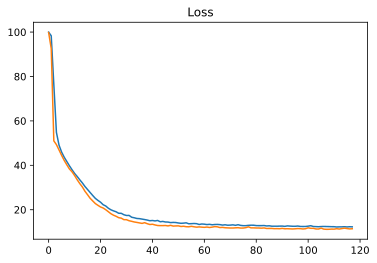

In [124]:
# Графики потерь
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [125]:
# Сохраняем веса лучшей модели
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [126]:
# Посмотрим на метрику MAPE
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.43%


## MAPE : 11.36% (14.88% - Baseline)

In [127]:
# Делаем сабмит
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

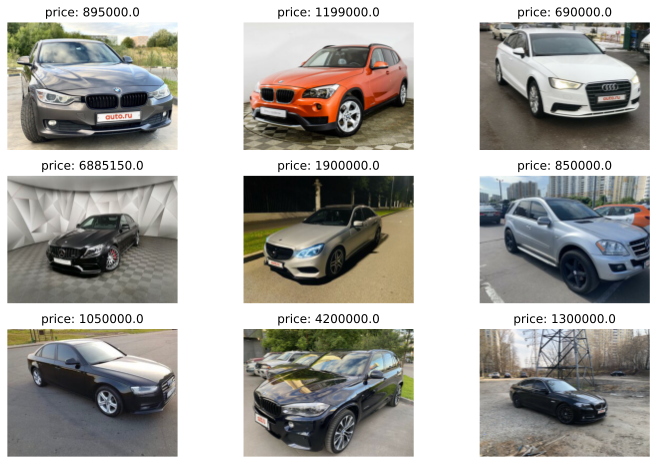

In [128]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [129]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

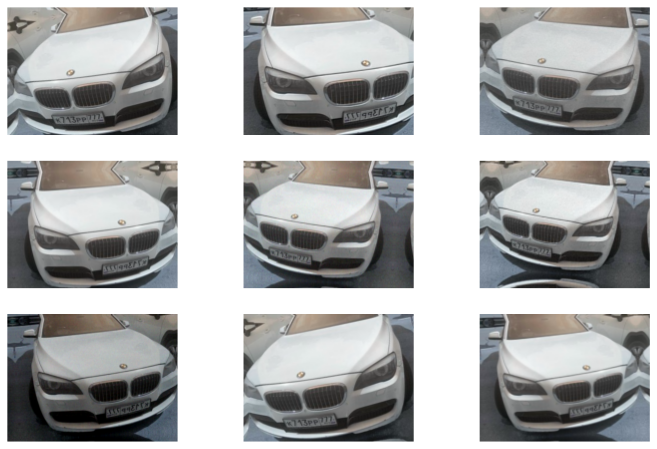

In [130]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [131]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
        print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [132]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [133]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [134]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [135]:
# Fine-tuning.
fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [136]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [137]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [138]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [139]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [140]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [141]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 92s 485ms/step - loss: 56.6829 - MAPE: 56.6829 - val_loss: 244.0282 - val_MAPE: 244.0282
Epoch 2/100
190/190 [==============================] - 90s 476ms/step - loss: 32.8912 - MAPE: 32.8912 - val_loss: 26.3846 - val_MAPE: 26.3846
Epoch 3/100
190/190 [==============================] - 89s 470ms/step - loss: 24.6349 - MAPE: 24.6349 - val_loss: 19.8265 - val_MAPE: 19.8265
Epoch 4/100
190/190 [==============================] - 92s 482ms/step - loss: 20.0294 - MAPE: 20.0294 - val_loss: 16.4156 - val_MAPE: 16.4156
Epoch 5/100
190/190 [==============================] - 89s 468ms/step - loss: 17.5883 - MAPE: 17.5883 - val_loss: 14.1106 - val_MAPE: 14.1106
Epoch 6/100
190/190 [==============================] - 89s 471ms/step - loss: 16.2369 - MAPE: 16.2369 - val_loss: 13.4497 - val_MAPE: 13.4497
Epoch 7/100
190/190 [==============================] - 88s 465ms/step - loss: 15.2919 - MAPE: 15.2919 - val_loss: 14.9742 - val_MAPE: 14.9742
Epoc

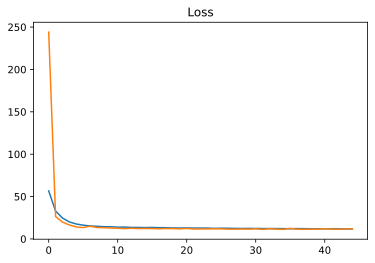

In [142]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [143]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [144]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.84%


In [145]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [146]:
# Checking the MAPE.
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.28%


In [147]:
# Submitting the results.
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [148]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [149]:
# Feature input + embeddings layers.
engineDisplacement = L.Input(
    shape=[1], 
    name="engineDisplacement"
)

emb_engineDisplacement = L.Embedding(
    len(X.engineDisplacement.unique().tolist())+1, 20
)(engineDisplacement)

f_engineDisplacement = L.Flatten()(emb_engineDisplacement)

In [150]:
# Combining the MLP and feature pass-through + head installing.
combinedInput = L.concatenate([model_mlp.output, f_engineDisplacement,])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_mlp.input, engineDisplacement], outputs=head)

In [151]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 181)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          93184       dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
engineDisplacement (InputLayer) [(None, 1)]          0                                            
_______________________________________________________________________________________

In [152]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [153]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 20ms/step - loss: 99.9908 - MAPE: 99.9908 - val_loss: 99.8877 - val_MAPE: 99.8877
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 98.8838 - MAPE: 98.8838 - val_loss: 94.7824 - val_MAPE: 94.7824
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 81.9758 - MAPE: 81.9758 - val_loss: 54.0667 - val_MAPE: 54.0667
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 54.2707 - MAPE: 54.2707 - val_loss: 50.0040 - val_MAPE: 50.0040
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 49.3499 - MAPE: 49.3499 - val_loss: 47.1564 - val_MAPE: 47.1564
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 45.8658 - MAPE: 45.8658 - val_loss: 44.5793 - val_MAPE: 44.5793
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 43.1846 - MAPE: 43.1846 - val_loss: 42.2760 - val_MAPE: 42.2760
Epoch 8/500
12/12 [=====================

In [154]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 11.59%


## Выводы
Что мы делали в проекте:

- Мы инициализировали необходимые библиотеки, задали условия визуализации и загрузили набор данных.
- Мы создали наивную модель в качестве отправной точки для оценки качества прогнозирования.
- Мы провели EDA, очистили и обработали входные данные.
- Мы обучили CatBoost 
- Мы обучили полносвязную нейросеть,  улучшили результат с помощью регуляризации и выбора гиперпараметров, дообучения ее при уменьшенном коэффициенте скорости обучения (Learning rate) и уменьшения размера батча
- Мы лемматизировали тексты, очищали их от символов и обучали NLP на основе полученных данных.
- Мы расширили изображения и обучили сверточную нейросеть, улучшив его результат с помощью тонкой настройки.
- Мы использовали смешивание для усреднения результатов.
- Мы экспериментировали с пробросом признака.
- На каждом этапе нам удалось улучшить производительность baseline по крайней мере на один процент.

Из полученных результатов можно сделать следующие выводы:

- Необходимо использовать наивную модель, чтобы иметь точку отсчета для оценки экспериментов.
- Уменьшение количества признаков, даже если они коррелируют друг с другом, снижает качество прогнозирования CatBoost.
- Использование логарифма числовых признаков улучшает качество табличных прогнозов NN.
- Регуляризация положительно влияет на качество предсказания полносвязной нейросети.
- Лемматизация и очистка символов улучшают качество предсказаний NLP NN.
- Смешивание последовательно помогает улучшить результаты, усредняя прогнозы из различных моделей.

По факту самый большой Public Score (11.57953) получила простая полносвязная нейросеть с регуляризацией и дообучением  при уменьшенном коэффициенте скорости обучения (Learning rate) и уменьшения размера батча